In [1]:
from perfetto.trace_processor import TraceProcessor
import numpy as np
import matplotlib.pyplot as plt

### Trace analysis, using counter trackers

Follow [this](https://perfetto.dev/docs/quickstart/trace-analysis) link for more understanding on counter trackers. We need tracker indexes for modem, frontend, mmWave and display (for benchmarking). Which are:

    1. 'power.rails.modem': 2
    2.'power.rails.radio.frontend': 3
    3. 'power.rails.VSYS_PWR_MMWAVE_uws': 1
    4. 'power.rails.display': 13

In [19]:
# Initialise TraceProcessor with a trace file
# tp = TraceProcessor(trace='trace_iperf.perfetto-trace')
# tp = TraceProcessor(trace='trace_5M_band66.perfetto-trace')
tp = TraceProcessor(trace='./Perfetto_traces/5_2_battery_trial.perfetto-trace') #10-15 dBm

# print(tp)
# select ts, t.name, value from counter as c left join counter_track t on c.track_id = t.i
qr_it = tp.query('SELECT ts,t.name,value,track_id FROM counter as c LEFT JOIN counter_track t ON c.track_id=t.id')
# print(qr_it)
qr_it_pandas = qr_it.as_pandas_dataframe()
print(qr_it_pandas[16:60])

# qr_it_pd2 = qr_it_pandas.filter(regex='power.rails.display')
# print(qr_it_pandas[qr_it_pandas['name']=='power.rails.display'])
# for row in qr_it:
#   print(row.id, row.type, row.name)

id_mapper = [25,26,27,28,2,3,1,13]
string_mapper = ["Battery charge","Battery capacity pct","Battery current","Battery avg current","Modem","RFE","mmWave","Display"]

                 ts                          name          value track_id
16  767542424000000     power.VSYS_PWR_MMWAVE_uws   1272666232.0        1
17  767542424000000             power.rails.modem  27013359865.0        2
18  767542424000000    power.rails.radio.frontend   1481305156.0        3
19  767542424000000  power.rails.memory.interface   7817635263.0        4
20  767542424000000           power.rails.cpu.big    326265626.0        5
21  767542424000000           power.rails.cpu.mid    347960982.0        6
22  767542424000000        power.rails.cpu.little   7282124250.0        7
23  767542424000000     power.rails.system.fabric    234547439.0        8
24  767542424000000           power.S8M_LLDO2_uws  21963503313.0        9
25  767542424000000      power.L15M_VDD_SLC_M_uws   5279291573.0       10
26  767542424000000               power.rails.tpu        66290.0       11
27  767542424000000           power.S6M_LLDO1_uws  23528014518.0       12
28  767542435000000           power.ra

In [16]:
qr_it = tp.query('SELECT * FROM counter')
# print(qr_it)
qr_it_pandas = qr_it.as_pandas_dataframe()
print(max(qr_it_pandas.track_id))
print(qr_it_pandas[16:30])

28
    id     type               ts track_id          value arg_set_id
16  16  counter  767542424000000        1   1272666232.0       26.0
17  17  counter  767542424000000        2  27013359865.0       26.0
18  18  counter  767542424000000        3   1481305156.0       26.0
19  19  counter  767542424000000        4   7817635263.0       26.0
20  20  counter  767542424000000        5    326265626.0       26.0
21  21  counter  767542424000000        6    347960982.0       26.0
22  22  counter  767542424000000        7   7282124250.0       26.0
23  23  counter  767542424000000        8    234547439.0       26.0
24  24  counter  767542424000000        9  21963503313.0       26.0
25  25  counter  767542424000000       10   5279291573.0       26.0
26  26  counter  767542424000000       11        66290.0       26.0
27  27  counter  767542424000000       12  23528014518.0       26.0
28  28  counter  767542435000000       13   6998555513.0       25.0
29  29  counter  767542435000000       14   3

In [17]:
df_list_cleaned = [tp.query('SELECT ts,value FROM counter WHERE track_id='+str(i)+'')
                   .as_pandas_dataframe().replace(np.nan,0)
                   .values.tolist() for i in id_mapper]
# import pdb;pdb.set_trace()
print(df_list_cleaned)

[[[767542419973246, 3240000.0], [767542501100850, 3240000.0], [767542752586283, 3240000.0], [767543001477763, 3240000.0], [767543250944234, 3240000.0], [767543503406514, 3240000.0], [767543751689311, 3240000.0], [767544001810567, 3240000.0], [767544251765239, 3240000.0], [767544502195333, 3240000.0], [767544752185039, 3240000.0], [767545001237122, 3240000.0], [767545252255555, 3240000.0], [767545502078879, 3240000.0], [767545751687196, 3240000.0], [767546001529522, 3240000.0], [767546251653586, 3240000.0], [767546501864564, 3240000.0], [767546751670880, 3240000.0], [767547001290753, 3240000.0], [767547251362571, 3240000.0], [767547500559430, 3240000.0], [767547752366233, 3240000.0], [767548002050641, 3240000.0], [767548252344912, 3240000.0], [767548501339419, 3240000.0], [767548751661807, 3240000.0], [767549001287702, 3240000.0], [767549251591820, 3240000.0], [767549501390160, 3240000.0], [767549751706811, 3240000.0], [767550001243269, 3240000.0], [767550251929711, 3240000.0], [7675505

Text(0.5, 0.98, 'Raw Values, can be checked with Perfetto UI')

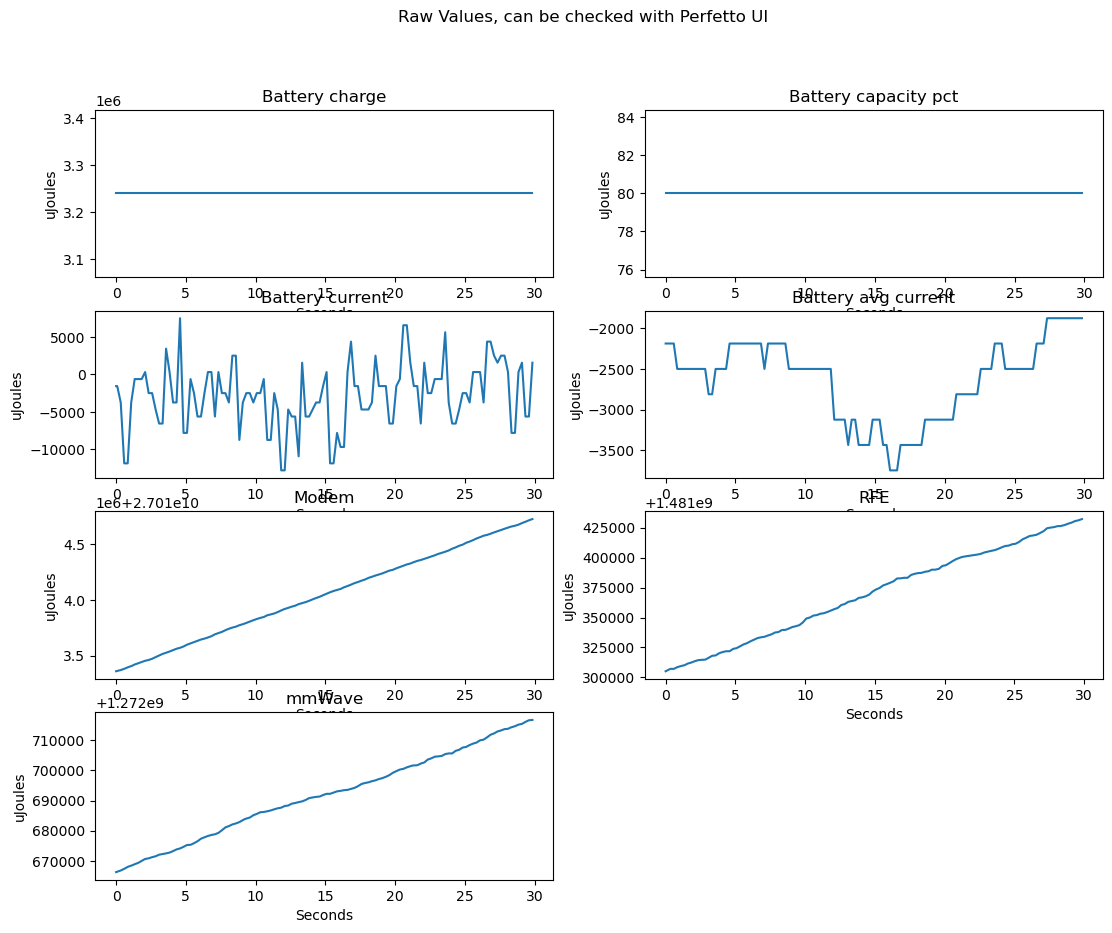

In [20]:
df_np = np.array(df_list_cleaned)
df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T 
df_np[:,:,0] = df_np[:,:,0]/1e9
# import pdb; pdb.set_trace()
plt.rcParams['figure.figsize'] = [13, 10]
for i in range(1,len(id_mapper)):
    plt.subplot(4,2,i)
    x_vals = df_np[i-1,:,0]
    y_vals = df_np[i-1,:,1] 
    plt.plot(x_vals,y_vals)
    plt.xlabel("Seconds")
    plt.ylabel("uJoules")
    plt.title(string_mapper[i-1])
plt.suptitle("Raw Values, can be checked with Perfetto UI")

In [ ]:
df_np = np.array(df_list_cleaned)
df_np[:,:,0] = df_np[:,:,0] - np.tile(df_np[:,0,0],[df_np.shape[1],1]).T 
df_np[:,:,0] = df_np[:,:,0]/1e9
# import pdb; pdb.set_trace()
plt.rcParams['figure.figsize'] = [13, 10]
for i in range(1,5):
    plt.subplot(2,2,i)
    x_vals = df_np[i-1,:,0]
    y_vals = df_np[i-1,:,1] 
    plt.plot(x_vals,y_vals)
    plt.xlabel("Seconds")
    plt.ylabel("uJoules")
    plt.title(string_mapper[i-1])
plt.suptitle("Raw Values, can be checked with Perfetto UI")

Average Power (mW) for Modem: 579.468779661017 mW
Average Power (mW) for RFE: 88.75142372881353 mW
Average Power (mW) for mmWave: 1.145322033898305 mW
Average Power (mW) for cellular (total): 669.3655254237287 mW
Average Power (mW) for Display: 135.968 mW


Text(0.5, 0.98, 'Delta Values, can be checked with Android Studio')

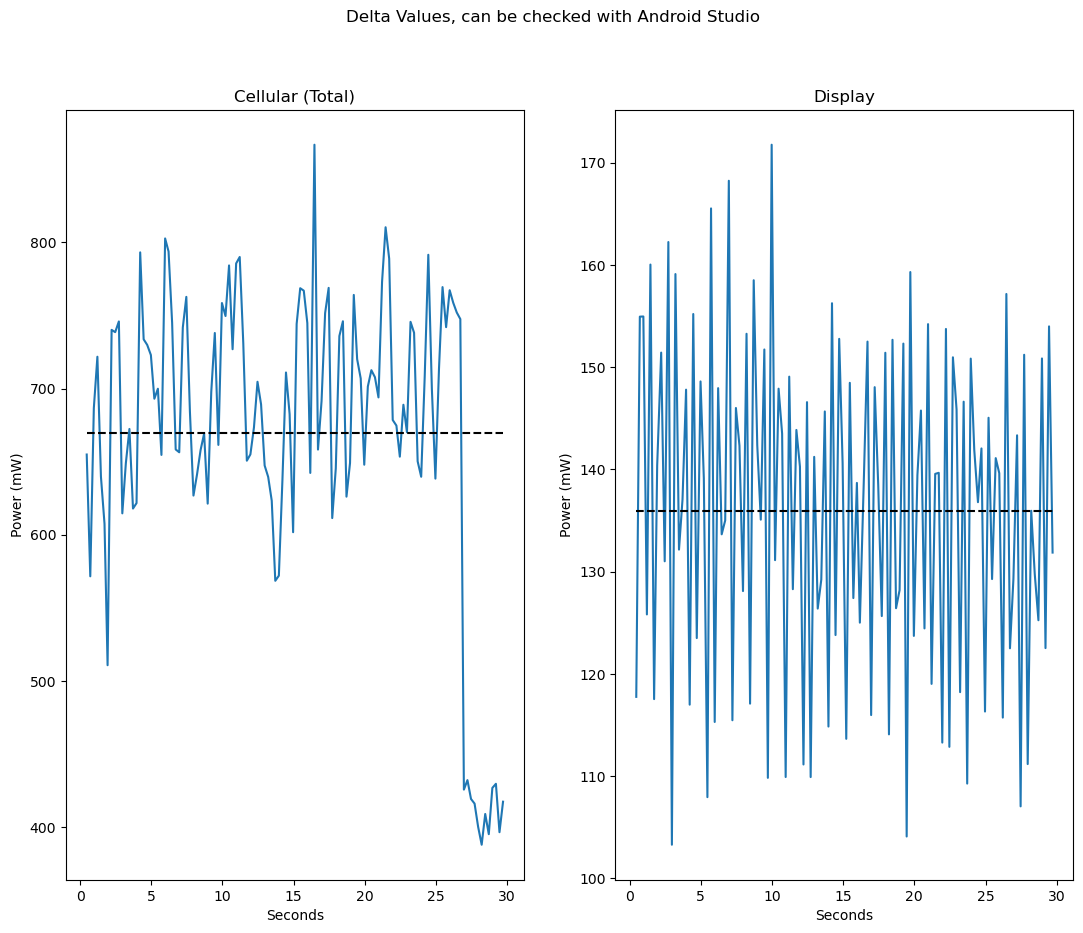

In [6]:
string_mapper_AS = ["Cellular (Total)","Display"]
plt.rcParams['figure.figsize'] = [13, 10]
summed_vals=np.zeros(df_np.shape[1])
initial_offset = 2
for i in range(1,5):
    x_vals = df_np[i-1,:,0]
    y_vals = df_np[i-1,:,1]
    delta_y_vals = np.copy(y_vals)
    delta_y_vals[1:] = delta_y_vals[1:]-delta_y_vals[0:y_vals.size-1]
    delta_y_vals[0] = 0
    avg_pow_indiv = np.mean(delta_y_vals[initial_offset:]*(4/1000))
    print("Average Power (mW) for "+str(string_mapper[i-1])+": "+str(avg_pow_indiv)+" mW")
#     import pdb; pdb.set_trace()
    if(i<=3):
        summed_vals = summed_vals + delta_y_vals
        if(i==3):
            plt.subplot(1,2,i-2)
            # *4 because power measurements done roughly over 250ms (1/4 seconds) interval
            # Making it mW by dividing by 1000
            plt.plot(x_vals[initial_offset:],summed_vals[initial_offset:]*(4/1000))
            avg_pow = np.mean(summed_vals[initial_offset:]*(4/1000))
            print("Average Power (mW) for cellular (total): "+str(avg_pow)+" mW")
            min_time = np.min(x_vals[initial_offset:])
            max_time = np.max(x_vals[initial_offset:])
            plt.plot([min_time,max_time],[avg_pow,avg_pow], linestyle="--", color="black")
            plt.xlabel("Seconds")
            plt.ylabel("Power (mW)")
            plt.title(string_mapper_AS[i-3])
#         summed_vals = 0
    else:
        plt.subplot(1,2,i-2)
        # *4 because power measurements done roughly over 250ms (1/4 seconds) interval
        plt.plot(x_vals[initial_offset:],delta_y_vals[initial_offset:]*(4/1000))
        min_time = np.min(x_vals[initial_offset:])
        max_time = np.max(x_vals[initial_offset:])
        plt.plot([min_time,max_time],[avg_pow_indiv,avg_pow_indiv], linestyle="--", color="black")
        plt.xlabel("Seconds")
        plt.ylabel("Power (mW)")
        plt.title(string_mapper_AS[i-3])
    
plt.suptitle("Delta Values, can be checked with Android Studio")